In [1]:
import numpy as np
import pandas as pd
from scipy.io import mmread

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 4)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import anndata as ad
import scanpy as sc
import maxfuse as mf

import seaborn as sns
import os


/Users/daisyding/opt/miniconda3/envs/omics/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data preprocessing

In [3]:
# read in protein data
data_dir = './../../../codex_augmentation/experiments/data'
protein = pd.read_csv(os.path.join(data_dir, 'tonsil/tonsil_codex.csv')) # ~178,000 codex cells

#protein = pd.read_csv("../data/tonsil/tonsil_codex.csv") # ~178,000 codex cells

In [ ]:
sns.scatterplot(data=protein, x="centroid_x", y="centroid_y", hue = "cluster.term", s = 0.1)

<Axes: xlabel='centroid_x', ylabel='centroid_y'>

In [4]:
# input csv contains meta info, take only protein features
protein_features = ['CD38', 'CD19', 'CD31', 'Vimentin', 'CD22', 'Ki67', 'CD8',
       'CD90', 'CD123', 'CD15', 'CD3', 'CD152', 'CD21', 'cytokeratin', 'CD2',
       'CD66', 'collagen IV', 'CD81', 'HLA-DR', 'CD57', 'CD4', 'CD7', 'CD278',
       'podoplanin', 'CD45RA', 'CD34', 'CD54', 'CD9', 'IGM', 'CD117', 'CD56',
       'CD279', 'CD45', 'CD49f', 'CD5', 'CD16', 'CD63', 'CD11b', 'CD1c',
       'CD40', 'CD274', 'CD27', 'CD104', 'CD273', 'FAPalpha', 'Ecadherin']
# convert to AnnData
protein_adata = ad.AnnData(
    protein[protein_features].to_numpy(), dtype=np.float32
)
protein_adata.var_names = protein[protein_features].columns

In [5]:
# read in RNA data
rna = mmread("../../../codex_augmentation/experiments/data/tonsil/tonsil_rna_counts.txt") # rna count as sparse matrix, 10k cells (RNA)
rna_names = pd.read_csv('../../../codex_augmentation/experiments/data/tonsil/tonsil_rna_names.csv')['names'].to_numpy()
# convert to AnnData
rna_adata = ad.AnnData(
    rna.tocsr(), dtype=np.float32
)
rna_adata.var_names = rna_names

In [6]:
rna_adata_raw = rna_adata

In [8]:
# read in celltyle labels
metadata_rna = pd.read_csv('../../codex_augmentation/experiments/data/tonsil/tonsil_rna_meta.csv')
labels_rna = metadata_rna['cluster.info'].to_numpy()
labels_codex = protein['cluster.term'].to_numpy()

Here we are integrating protein and RNA data, and most of the time there are name differences between protein (antibody) and their corresponding gene names. 

These "weak linked" features will be used during initialization (we construct two arrays, `rna_shared` and `protein_shared`, whose columns are matched, and the two arrays can be used to obtain the initial matching). 

To construct the feature correspondence in straight forward way, we prepared a ```.csv``` file containing most of the antibody name (seen in cite-seq or codex antibody names etc) and their corresponding gene names:


In [1]:
correspondence = pd.read_csv('./../../protein_gene_conversion.csv')
#correspondence.head()

In [10]:
rna_protein_correspondence = []

for i in range(correspondence.shape[0]):
    curr_protein_name, curr_rna_names = correspondence.iloc[i]
    if curr_protein_name not in protein_adata.var_names:
        continue
    if curr_rna_names.find('Ignore') != -1: # some correspondence ignored eg. protein isoform to one gene
        continue
    curr_rna_names = curr_rna_names.split('/') # eg. one protein to multiple genes
    for r in curr_rna_names:
        if r in rna_adata.var_names:
            rna_protein_correspondence.append([r, curr_protein_name])
            
rna_protein_correspondence = np.array(rna_protein_correspondence)

In [9]:
# Columns rna_shared and protein_shared are matched.
# One may encounter "Variable names are not unique" warning,
# this is fine and is because one RNA may encode multiple proteins and vice versa.
rna_shared = rna_adata[:, rna_protein_correspondence[:, 0]].copy()
protein_shared = protein_adata[:, rna_protein_correspondence[:, 1]].copy()

/Users/daisyding/opt/miniconda3/envs/omics/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/daisyding/opt/miniconda3/envs/omics/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Then we retrieve the shared features. Normally we should not use all the shared featues, as some of the shared feature RNA are not very variable, and inputing low quality features could potentially decrease the performance of ```MaxFuse```. In this case we only use RNA or Protein features that are variable (larger than a certain threshold).

In [10]:
# Make sure no column is static
mask = (
    (rna_shared.X.toarray().std(axis=0) > 0.5) 
    & (protein_shared.X.std(axis=0) > 0.1)
)
rna_shared = rna_shared[:, mask].copy()
protein_shared = protein_shared[:, mask].copy()
print([rna_shared.shape,protein_shared.shape])

[(12977, 32), (178919, 32)]


We apply standard Scanpy preprocessing steps to `rna_shared`.
We skipped the processing steps for `protein_shared` because the input CODEX data was already normalized et.

In [11]:
# process rna_shared
sc.pp.normalize_total(rna_shared)
sc.pp.log1p(rna_shared)
sc.pp.scale(rna_shared)
rna_shared = rna_shared.X.copy()

/Users/daisyding/opt/miniconda3/envs/omics/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


In [12]:
protein_shared = protein_shared.X.copy()

We again apply standard Scanpy preprocessing steps to **all available RNA measurements and protein measurements** (not just the shared ones) to get two arrays, `rna_active` and `protein_active`, which are used for iterative refinement. Again if the input data is already processed, these steps can be skipped.

In [13]:
# process all RNA features
sc.pp.normalize_total(rna_adata)
sc.pp.log1p(rna_adata)
sc.pp.highly_variable_genes(rna_adata, n_top_genes=5000)
# only retain highly variable genes
rna_adata = rna_adata[:, rna_adata.var.highly_variable].copy()
sc.pp.scale(rna_adata)

In [14]:
# make sure no feature is static
rna_active = rna_adata.X
protein_active = protein_adata.X
rna_active = rna_active[:, rna_active.std(axis=0) > 1e-5] # these are fine since already using variable features
protein_active = protein_active[:, protein_active.std(axis=0) > 1e-5] # protein are generally variable

In [15]:
rna_active.shape

(12977, 5000)

In [16]:
protein_active.shape

(178919, 46)

## Fitting MaxFuse

### Step I: preparations

In [17]:
# call constructor for Fusor object
# which is the main object for running MaxFuse pipeline
fusor = mf.model.Fusor(
    shared_arr1=rna_shared,
    shared_arr2=protein_shared,
    active_arr1=rna_active,
    active_arr2=protein_active,
    labels1=None,
    labels2=None
)

In [18]:
fusor.split_into_batches(
    max_outward_size=8000,
    matching_ratio=4,
    metacell_size=2,
    verbose=True
)

The first data is split into 1 batches, average batch size is 12977, and max batch size is 12977.
The second data is split into 5 batches, average batch size is 35783, and max batch size is 35787.
Batch to batch correspondence is:
  ['0<->0', '0<->1', '0<->2', '0<->3', '0<->4'].


The next step is to construct appropriate nearest-neighbor graphs for each modality with all features available.
But before that, we plot the singular values of the two active arrays to determine how many principal components (PCs) to keep when doing graph construction.

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

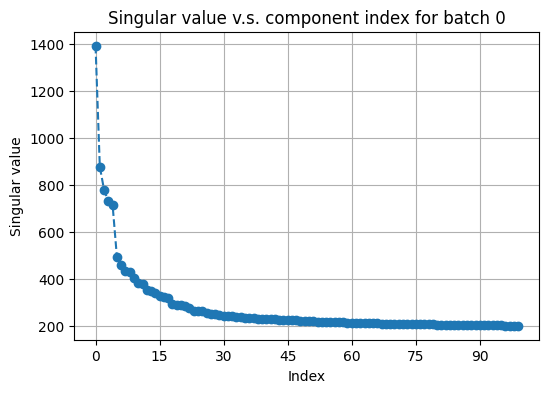

In [19]:
# plot top singular values of avtive_arr1 on a random batch
fusor.plot_singular_values(
    target='active_arr1',
    n_components=None # can also explicitly specify the number of components
)

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 1'}, xlabel='Index', ylabel='Singular value'>)

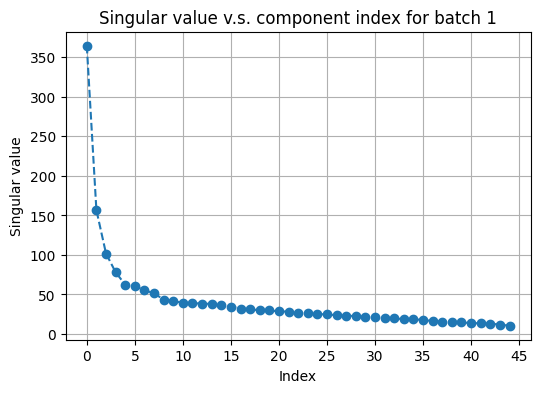

In [20]:
# plot top singular values of avtive_arr2 on a random batch
fusor.plot_singular_values(
    target='active_arr2',
    n_components=None
)

Inspecting the "elbows", we choose the number of PCs to be **40** for both RNA and  **15** for protein active data.
We then call `construct_graphs` to compute nearest-neighbor graphs as needed.

In [21]:
fusor.construct_graphs(
    n_neighbors1=15,
    n_neighbors2=15,
    svd_components1=40,
    svd_components2=15,
    resolution1=2,
    resolution2=2,
    # if two resolutions differ less than resolution_tol
    # then we do not distinguish between then
    resolution_tol=0.1,
    verbose=True
)

Aggregating cells in arr1 into metacells of average size 2...
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Graph construction finished!
Clustering into metacells...
Now at batch 0...
Metacell clustering finished!
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Graph construction finished!
Clustering the graphs for cells in arr1...
Now at batch 0...
Graph clustering finished!
Constructing neighborhood graphs for cells in arr2...
Now at batch 0...
Now at batch 1...
Now at batch 2...
Now at batch 3...
Now at batch 4...
Graph construction finished!
Clustering the graphs for cells in arr2...
Now at batch 0...
Now at batch 1...
Now at batch 2...
Now at batch 3...
Now at batch 4...
Graph clustering finished!


### Step II: finding initial pivots

We then use shared arrays whose columns are matched to find initial pivots.
Before we do so, we plot top singular values of two shared arrays to determine how many PCs to use.

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

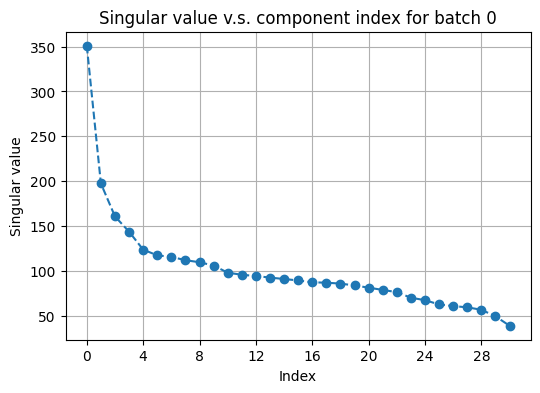

In [22]:
# plot top singular values of shared_arr1 on a random batch
fusor.plot_singular_values(
    target='shared_arr1',
    n_components=None,
)

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

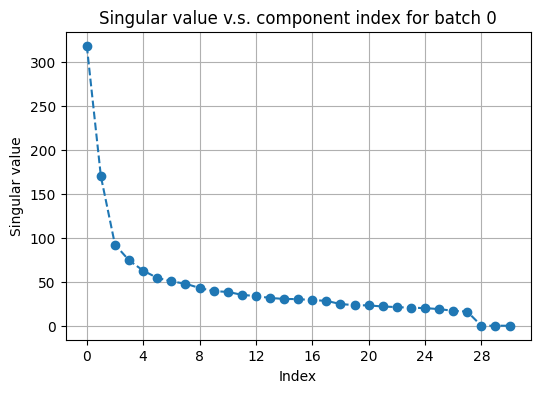

In [23]:
# plot top singular values of shared_arr2 on a random batch
fusor.plot_singular_values(
    target='shared_arr2',
    n_components=None
)

In [24]:
fusor.find_initial_pivots(
    wt1=0.3, wt2=0.3,
    svd_components1=25, svd_components2=20
)

Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 0<->3...
Now at batch 0<->4...
Done!


### Step III: finding refined pivots

We now use the information in active arrays to iteratively refine initial pivots.
We plot the top canonical correlations to choose the best number of components in canonical correlation analysis (CCA).

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Canonical correlation v.s. component index for batch 0<->3'}, xlabel='Index', ylabel='Canonical correlation'>)

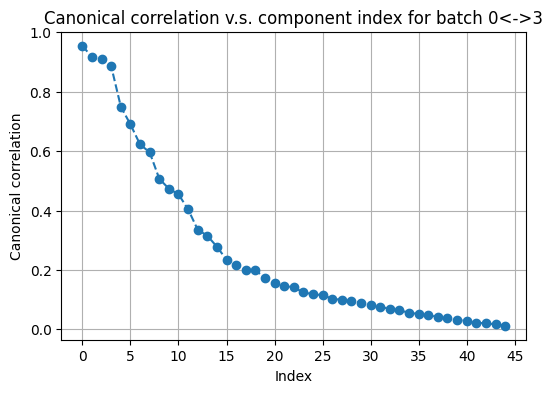

In [25]:
# plot top canonical correlations in a random batch
fusor.plot_canonical_correlations(
    svd_components1=50,
    svd_components2=None,
    cca_components=45
)

In [26]:
fusor.refine_pivots(
    wt1=0.3, wt2=0.3,
    svd_components1=40, svd_components2=None,
    cca_components=25,
    n_iters=1,
    randomized_svd=False, 
    svd_runs=1,
    verbose=True
)

Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 0<->3...
Now at batch 0<->4...
Done!


In [27]:
fusor.filter_bad_matches(target='pivot', filter_prop=0.5)

Begin filtering...
Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 0<->3...
Now at batch 0<->4...
16200/32395 pairs of matched cells remain after the filtering.
Fitting CCA on pivots...
Scoring matched pairs...
8888/12977 cells in arr1 are selected as pivots.
16200/178919 cells in arr2 are selected as pivots.
Done!


In [28]:
pivot_matching = fusor.get_matching(order=(2, 1),target='pivot')

lv1_acc = mf.metrics.get_matching_acc(matching=pivot_matching, 
    labels1=labels_rna, 
    labels2=labels_codex,
    order = (2,1)
)
lv1_acc

0.9576543209876544

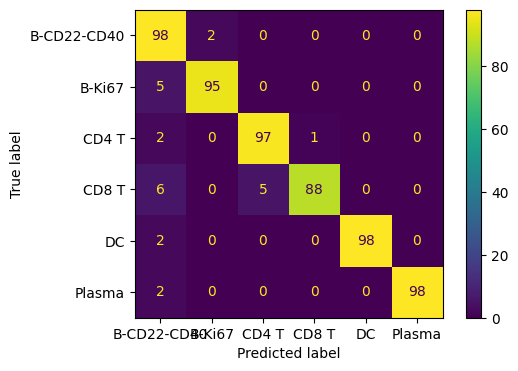

In [29]:
cm = confusion_matrix(labels_rna[pivot_matching[0]], labels_codex[pivot_matching[1]])
ConfusionMatrixDisplay(
    confusion_matrix=np.round((cm.T/np.sum(cm, axis=1)).T*100), 
    display_labels=np.unique(labels_rna)
).plot()

### Step IV: propagation

Refined pivots can only give us a pivot matching that captures a subset of cells. In order to get a *full* matching that involves all cells during input, we need to call `propagate`.


In [30]:
fusor.propagate(
    svd_components1=40, 
    svd_components2=None, 
    wt1=0.7,
    wt2=0.7,
)

Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 0<->3...
Now at batch 0<->4...
Done!


In [31]:
fusor.filter_bad_matches(
    target='propagated',
    filter_prop=0.3
)

Begin filtering...
Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 0<->3...
Now at batch 0<->4...
125238/178914 pairs of matched cells remain after the filtering.
Scoring matched pairs...
Done!


In [32]:
full_matching = fusor.get_matching(order=(2, 1), target='full_data')

In [41]:
len(full_matching[0])

141438

In [33]:
pd.DataFrame(list(zip(full_matching[0], full_matching[1], full_matching[2])), 
             columns = ['mod1_indx', 'mod2_indx', 'score'])
# columns: cell idx in mod1, cell idx in mod2, and matching scores

,mod1_indx,mod2_indx,score
0,11555,0,0.677698
1,12419,13,0.829264
2,6964,26,0.743796
3,12027,35,0.633725
4,3463,38,0.873877
...,...,...,...
141433,6516,178913,0.650691
141434,6380,178915,0.752489
141435,11798,178916,0.624662
141436,6516,178917,0.598526


In [42]:
df_res = pd.DataFrame(list(zip(full_matching[0], full_matching[1], full_matching[2])), 
             columns = ['mod1_indx', 'mod2_indx', 'score'])
df_res.to_csv('tonsil_codex_rna.csv', index=False)